# ARHMM Tutorial

## 1 What is an ARHMM?

Though HMMs are powerful probabilistic models, they are actually relatively constrained examples of more general graphical models like Bayesian networks or Markov random fields. While these generalizations are useful at times, their additional flexibility can dramatically increase the computational complexity of many algorithms. In some cases, exact calculations are intractable. Here we'll discuss one small extension of HMMs that can improve their ability to model correlations between emissions while still employing the same efficient algorithms.

In normal HMMs, the emission distributions depend only on the current state. Autoregressive HMMs (ARHMMs) make one small tweak to this structure by making the emission distributions depend on the current state **and** the previous emission. Graphically, if an HMM is represented by the typical lattice diagram shown below where boxes, circles, and arrows represent states, emissions, and probabilistic dependencies, respectively, then an ARHMM is equivalent to drawing an arrow from the previous state to the current one.

![trellis](../assets/trellis.png)

## 2 Bull and Bear Markets

Let's introduce ARHMMs with a relatively simple stock market example. First, though, we need to import Homomorph and some helper packages since we'll be using them shortly.

In [1]:
import sys
sys.path = ['../src'] + sys.path

import homomorph
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

### 2.1 Motivation and theory

#### 2.2.1 Stock prices as autoregressive sequences

At any moment the stock price of a company is a record of its value when one unit last traded hands, and these prices reflect the feelings of the parties involved in the trade. Often these feelings are founded in evidence. For example, the latest earnings report showed steady growth and record profits. On other occasions, they're based on more emotional factors, like the sense that prices can only go up or the desire to [exact revenge](https://en.wikipedia.org/wiki/GameStop_short_squeeze) on a corrupt financial establishment. Regardless of their origin, these feelings determine prices, and sometimes the feelings are broadly optimistic. These periods correspond to periods of sustained growth in prices known as a bull market. Other times there's doom and gloom on the horizon, the bear market takes hold, and prices fall.

We can make a simple model of this behavior using an ARHMM. ARHMMs are a good fit for the stock market because we expect the price tomorrow to not deviate too greatly from the price today. To phrase this idea more precisely, even though the jumps between days might follow a consistent distribution, we still need to know the previous day's price to correctly place the endpoint of each jump. To be clear, an ARHMM isn't *strictly* necessary under an assumption of identical and independently distributed (iid) jumps. It's also possible to pre-process observed data by taking differences between subsequent days. This yields a sequence of jumps that can be modeled by a largely equivalent HMM. (There are some minor differences in the treatment of the first emission.) Despite this, ARHMMs are the more powerful framework because they allow an end-to-end treatment of the data (i.e. no pre-processing) and do not require the simplifying assumption of iid jumps.

So far I've used the term jump loosely and suggested we're modeling them as a subtraction between subsequent days. This "additive" model is not the best fit to stock prices for two reasons. First, to allow prices to both increase and decrease, we need to allow negative jumps. However, this may result in negative stock prices if there are too many jumps down when the price is low. Second, the perception of price is more closely multiplicative than additive. For example, a \\$10 stock gaining another \\$10 is much more significant than the same gain for a \\$1000 stock.

#### 2.2.2 Geometric Brownian motion

The conventional "multiplicative" model of stock prices is called geometric Brownian motion and takes a specific form defined by the following stochastic differential equation

$$ dS_t = \mu S_t dt + \sigma S_t dB_t $$

where $S_t$ is the stochastic process, $\mu$ is the drift, $\sigma$ is the volatility, and $B_t$ is a standard Brownian motion. The drift and volatility are constants which parametrize the average growth or decay of the process and its variation, respectively.

Don't worry too much about the exact meaning of this equation. Stochastic differential equations are an advanced topic that are rarely covered in detailed in even undergraduate probability courses. The important take-away for us is the value of the process changes according to both a deterministic and stochastic part. The deterministic part is proportional to $\mu$ and the current value of the process. The stochastic part is proportional to $\sigma$, the current value of the process, and a standard Brownian differential $dB_t$. Roughly speaking a standard Brownian differential is a like small step sampled from a normal distribution, which is actually how we'll simulate it later.

Fortunately for us the previous equation has the analytic solution

$$ S_t = S_0 \exp \left( \left( \mu - \frac{\sigma^2}{2} \right)t + \sigma B_t \right) $$

where $S_0$ is the initial value of the process. This gives us an explicit formula for calculating the value of the process at any time. (Technically speaking a standard Brownian motion is a continuous process, but we easily generate a discrete analog by accumulating a sequence of normal variates.) As a quick note, the `ARHMM` generates simulations sequentially, so technically we take $t = 1$ in the above equation, and generate one step at a time. Don't worry, this is equivalent to accumulating a sequence of normal variates which can be shown by expanding $S_t$ in terms of single steps.

We also need a expression for its pdf for some later calculations:

$$
f_{S_t}(x; \mu, \sigma, t)
=
\frac{1}{x \sigma \sqrt{2 \pi t}}
\exp{\left(-\frac{\left(\ln x - \ln S_0
                        - (\mu - \frac{1}{2} \sigma^2)t
                  \right)^2}
                 {2 \sigma^2 t}
     \right)}
$$

### 2.2 Instantiating the model

With the motivation and theory out of the way, let's actually build an ARHMM! If you've followed the [HMM tutorial](https://github.com/marcsingleton/homomorph/blob/main/tutorials/hmm_intro.ipynb), most of what follows should be familiar. I'll focus exclusively on the features unique to the `ARHMM` class, so if you have any questions about the other arguments, please refer to the HMM tutorial.

The first difference is in the arguments of the methods of the emission distributions. Since they depend on the previous emission, we'll need to make some minor adjustments to the SciPy conventions. Unfortunately, this also means we can't directly use SciPy random variables, so we'll have to make a custom class. Although SciPy random variables implement many methods, the `ARHMM` class only uses the `rvs` and `pdf` or `pmf` methods, so we only need to supply those. Since the distributions also need to remember their parameters, we'll create a class that directly returns a "frozen" random variable.

In [2]:
class GBM_rv:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def rvs(self, x):
        d = self.mu - self.sigma ** 2 / 2
        s = self.sigma * stats.norm.rvs()
        return x * np.exp(d + s)
    
    def pdf(self, x):
        x0, x1 = x
        sigma2 = self.sigma ** 2
        c = 1 / (x1 * self.sigma * (2*np.pi) ** 0.5)
        n = (np.log(x1/x0) - self.mu + 0.5 * sigma2) ** 2
        d = 2 * sigma2
        return c * np.exp(-n / d)

We'll go ahead and create the random variables for each state. We can choose the parameters blindly, but it's actually a little tricky to set them correctly to make the resulting sample paths look like plausible stock prices. The problem is $\mu$ and $\sigma$ are not directly related to intuitive measures like annual growth rate or the coefficient of variation. Fortunately with a small amount of work we can relate these quantities.

Let's quickly review the equations for the expected value and variance of $S_t$ since we'll need them for our derivations.

$$
E(S_t) = S_0 e^{\mu t} \\
Var(S_t) = S_0^2e^{2 \mu t} \left(e^{\sigma^2 t} - 1 \right)
$$

A nice measure for the growth of an investment is the average annual growth rate (AAGR), which we can easily relate to $\mu$ from the equation for expected value.

$$
E(S_{365}) = S_0 e^{365 \mu} \\
\log \left( \frac{E(S_{365})}{S_0} \right) = 365 \mu \\
\frac{\log \left( AAGR \right)}{365} = \mu \\
$$

The variance is trickier to think about since it's expressed in square units. A more intuitive quantity is the coefficient of variation (CV), which is the ratio of the standard deviation to the mean. We'll begin with deriving an equation for CV.

$$
\begin{aligned}
CV(S_t) &= \frac{\sqrt{Var(S_t)}}{E(S_t)} \\
&= \frac{\sqrt{S_0^2e^{2 \mu t} \left(e^{\sigma^2 t} - 1 \right)}}
        {S_0 e^{\mu t}} \\
&= \sqrt{e^{\sigma^2 t} - 1 }
\end{aligned}
$$

Now let's re-arrange this equation to express $\sigma$ in terms of the CV after one year.

$$
CV(S_{365}) = \sqrt{e^{365 \sigma^2} - 1 } \\
CV(S_{365})^2 + 1 = e^{365 \sigma^2} \\
\sqrt{\frac{\log{CV(S_{365})^2 + 1}}{365}} = \sigma
$$

In [3]:
aagr_bull = 1.075
aagr_bear = 0.90
cv_bull = 0.075
cv_bear = 0.09

mu_bull = np.log(aagr_bull) / 365
mu_bear = np.log(aagr_bear) / 365
sigma_bull = (np.log(cv_bull**2 + 1) / 365) ** 0.5
sigma_bear = (np.log(cv_bear**2 + 1) / 365) ** 0.5

GBM_bull = GBM_rv(mu_bull, sigma_bull)
GBM_bear = GBM_rv(mu_bear, sigma_bear)

The second difference is the `ARHMM` class requires a `start_e_dist` argument. As you just saw, we constructed the emission distributions to explicitly depend on the previous emission. However, the first emission doesn't have a previous emission, so the behavior in this case is undefined! The probabilistically principled approach would be to treat the previous emission as an unobserved variable and sum over all possible values to obtain a marginal distribution for the first emission. For reasons of simplicity and flexibility, though, the `ARHMM` class asks you to explicitly provide a start emission distribution instead.

To keep things simple, we'll make our stock prices always start at a constant value of 100. We can even imagine a company is about to IPO, and the finance team has set this as the initial price. SciPy doesn't provide a "constant" random variable, so we'll have to make it ourselves. As before, we need to define an class with `pdf` and `rvs` methods. Luckily this is extremely simple.

In [4]:
class constant_rv:
    def __init__(self, c):
        self.c = c
    
    def rvs(self):
        return self.c
    
    def pdf(self, x):
        if x == self.c:
            return 1
        else:
            return 0

Now that we've built all the pieces, let's put them together and instantiate an `ARHMM`! To spice things up a little, we'll make it random whether it starts in a bull or bear market. We won't be too cruel to our company, so we'll tilt the odds in favor of the bull market.

In [5]:
stock = homomorph.ARHMM(t_dists={'bull': {'bull': 0.999, 'bear': 0.001}, 'bear': {'bull': 0.005, 'bear': 0.995}},
                        e_dists={'bull': GBM_bull, 'bear': GBM_bear},
                        start_t_dist={'bull': 0.9, 'bear': 0.1},
                        start_e_dists={'bull': constant_rv(100), 'bear': constant_rv(100)},
                        name='AR Corp')
stock

ARHMM(states={'bull', 'bear'},
      stop_states=None,
      name='AR Corp')

### 2.3 Calculations with ARHMMs

If you've read the HMM tutorial, then you should be familiar with using the `HMM` class to simulate data and calculate various quantities. The `ARHMM` supports all the same operations, so I'll quickly demonstrate each. What follows largely serves as a test of the implementations, so I won't provide any context or explanation. If you have any questions, please refer to the HMM tutorial.

#### 2.3.1 Simulation

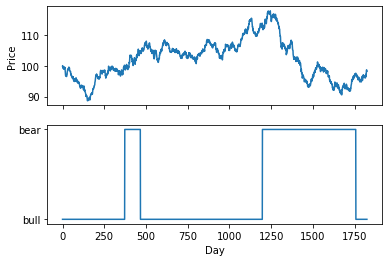

In [6]:
step_num = 365 * 5  # Five year projection
np.random.seed(12)
steps = stock.simulate(step_num)
states = [step[0] for step in steps]
emits = [step[1] for step in steps]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states)
axs[1].set_xlabel('Day')
axs[0].set_ylabel('Price');

#### 2.3.2 Emission probability (forward algorithm)

In [7]:
fs, ss = stock.forward(emits)
print(fs['bull'][:5])
print(fs['bear'][:5])

[0.9, 0.9162192187480763, 0.8791282358476881, 0.8954647674978955, 0.8627969604737894]
[0.1, 0.08378078125192372, 0.12087176415231184, 0.10453523250210452, 0.13720303952621057]


#### 2.3.3 State inference (Viterbi algorithm)

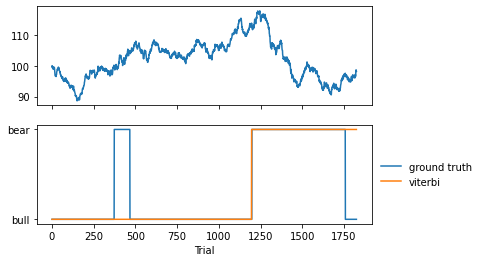

In [8]:
viterbi = stock.viterbi(emits)[0]

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states, label='ground truth')
axs[1].plot(viterbi, label='viterbi')
axs[1].set_xlabel('Trial')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

#### 2.3.4 State inference (forward-backward algorithm)

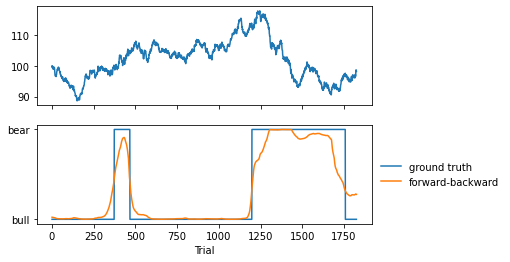

In [9]:
fbs = stock.forward_backward(emits)

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(emits)
axs[1].plot(states, label='ground truth')
axs[1].plot(fbs['bear'], label='forward-backward')
axs[1].set_xlabel('Trial')
axs[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));

## 3 A coin flipping game

AR(1) binomial example

While I don't have a compelling real-world motivation to motivate this next example, I do find it interesting illustration of how it's not always immediately obvious how to construct an autoregressive model with certain properties.